In [87]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [88]:
device = torch.device("cuda")

In [89]:
def getFilePaths(path):
    filelist = []

    for root, dirs, files in os.walk(path):
        for file in files:
            filelist.append(os.path.join(root,file))
            
    return filelist

In [90]:
train_data_path = "./chinese-handwriting/CASIA-HWDB_Train/Train/"
test_data_path = "./chinese-handwriting/CASIA-HWDB_Test/Test/"

vocabulary_list = ["起","果","热","院","四","回","西","国","高","怎","系","北","一","七","三","上","下","不","东","子","医","字","个","十","中","午","气","学","么","开","水","九","习","书","汉","雨","买","见","视","零","觉","了","二","在","五","些","生","坐","电","块","影","很","校","客","样","家","桌","去","京","亮","想","友","人","没","什","对","今","叫","他","们","面","候","苹","做","小","少","吃","同","名","后","吗","听","会","爱","爸","租","呢","住","岁","作","你","和","茶","椅","的","车","站","那","钟","哪","狗","认","识","话","日","都","语","时","菜","说","请","读","儿","先","钱","我","八","六","老","关","兴","这","再","写","打","商","猫","谁","明","星","昨","飞","谢","是","喂","多","喜","喝","大","天","冷","看","太","几","出","女","她","好","睡","妈","工","现","衣","能","里","分","饭","馆","姐","前","欢","师","脑","火","漂","月","有","朋","服","年","期","本","米","店","机","来","杯","点"]

In [91]:
image_size = 64
batch_size =  64
composed_transform = transforms.Compose([transforms.Resize(image_size), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

In [92]:
class CharacterDataset(Dataset):
    def __init__(self, data_path, transforms):
        self.transforms = transforms
        self.images = getFilePaths(data_path)
    def __len__ (self):
            return len(self.images)
    def __getitem__(self, idx):
        character_path = self.images[idx]
        
        image = Image.open(character_path)
        image = self.transforms(image)
        
        character = character_path.split('/')[-2]
        character_vector = vocabulary_list.index(character)
        character_vector = np.asarray(character_vector)
        character_vector = torch.from_numpy(character_vector)
        
        return image, character_vector
        

train_dataset = CharacterDataset(train_data_path, composed_transform)
trainloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

test_dataset = CharacterDataset(test_data_path, composed_transform)
testloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)


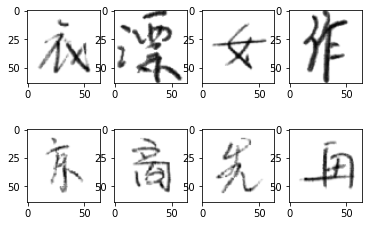

In [93]:
idx = 0

image, label = next(iter(trainloader))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(image[i].cpu().view(64, 64), cmap="gray")

In [94]:
class Recognizer(nn.Module):
    def __init__(self):
        super(Recognizer, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.drop = nn.Dropout2d(0.25)
        
        self.fc1 = nn.Linear(32 * 16 *16, 2048)
        self.fc2 = nn.Linear(2048, 712)
        self.fc3 = nn.Linear(712, 178)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        x = x.view(-1, 32 * 16 * 16)
        x = self.drop(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [95]:
model = Recognizer().to(device)

In [96]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
save_interval = 200

In [97]:
load_model = False
if load_model:
    model.load_state_dict(torch.load('recognizer.pth'))

In [98]:
model.train()
loss_hist = []

for epoch in range(epochs):
    for idx, (image, label) in enumerate(dataloader):
        optimizer.zero_grad()
        
        image, label = image.to(device), label.to(device)
        
        prediction = model(image)
        loss = criterion(prediction, label)
        
        loss.backward()
        optimizer.step()
        
        if idx % save_interval == 0:
            loss_hist.append(loss.item())
            print(f'Epoch: {epoch} / {epochs} Batch:: {idx}/{len(dataloader)} Loss: {loss}')
        

Epoch: 0 / 10 Batch:: 0/1665 Loss: 5.227470874786377
Epoch: 0 / 10 Batch:: 200/1665 Loss: 2.635887622833252
Epoch: 0 / 10 Batch:: 400/1665 Loss: 1.7988927364349365
Epoch: 0 / 10 Batch:: 600/1665 Loss: 1.6637773513793945
Epoch: 0 / 10 Batch:: 800/1665 Loss: 2.0079596042633057
Epoch: 0 / 10 Batch:: 1000/1665 Loss: 1.0397632122039795
Epoch: 0 / 10 Batch:: 1200/1665 Loss: 0.9047157764434814
Epoch: 0 / 10 Batch:: 1400/1665 Loss: 0.7901557087898254
Epoch: 0 / 10 Batch:: 1600/1665 Loss: 0.8475754261016846
Epoch: 1 / 10 Batch:: 0/1665 Loss: 0.5085000395774841
Epoch: 1 / 10 Batch:: 200/1665 Loss: 0.5234728455543518
Epoch: 1 / 10 Batch:: 400/1665 Loss: 0.6118471026420593
Epoch: 1 / 10 Batch:: 600/1665 Loss: 0.6510483622550964
Epoch: 1 / 10 Batch:: 800/1665 Loss: 0.4033169746398926
Epoch: 1 / 10 Batch:: 1000/1665 Loss: 0.7401185035705566
Epoch: 1 / 10 Batch:: 1200/1665 Loss: 0.47833359241485596
Epoch: 1 / 10 Batch:: 1400/1665 Loss: 0.6345211863517761
Epoch: 1 / 10 Batch:: 1600/1665 Loss: 0.404834

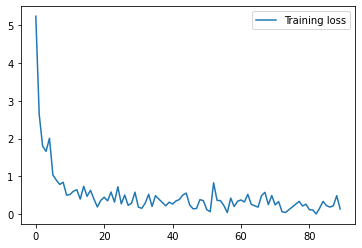

In [99]:
plt.plot(loss_hist, label="Training loss")
plt.legend()
plt.show()

In [100]:
torch.save(model.state_dict(), 'recognizer.pth')

站
站


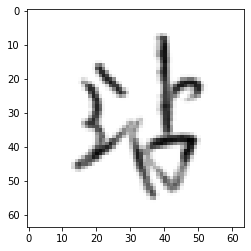

In [101]:
idx = 2

print(vocabulary_list[label[idx]])
print(vocabulary_list[prediction[idx].argmax(-1)])
plt.imshow(image[idx].cpu().view(64, 64), cmap="gray")

In [102]:
class_correct = [0. for _ in range(178)]
total_correct = [0. for _ in range(178)]

model.eval()

with torch.no_grad():
    for idx, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)
        
        predictions = model(images)
        predictions = predictions.argmax(-1)
        
        compare = (predictions == labels).squeeze()
        
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += compare[i].item()
            total_correct[label] += 1


In [103]:
for i in range(178):
    print("{} accuracy: {:.3f}%".format(vocabulary_list[i], class_correct[i] * 100 / total_correct[i]))

起 accuracy: 92.642%
果 accuracy: 98.833%
热 accuracy: 91.122%
院 accuracy: 97.837%
四 accuracy: 68.634%
回 accuracy: 98.829%
西 accuracy: 96.327%
国 accuracy: 96.167%
高 accuracy: 97.171%
怎 accuracy: 98.331%
系 accuracy: 95.500%
北 accuracy: 85.880%
一 accuracy: 99.334%
七 accuracy: 96.167%
三 accuracy: 95.134%
上 accuracy: 98.492%
下 accuracy: 96.833%
不 accuracy: 95.530%
东 accuracy: 90.516%
子 accuracy: 99.330%
医 accuracy: 98.170%
字 accuracy: 96.141%
个 accuracy: 92.857%
十 accuracy: 98.319%
中 accuracy: 96.141%
午 accuracy: 87.687%
气 accuracy: 96.828%
学 accuracy: 96.828%
么 accuracy: 95.093%
开 accuracy: 98.998%
水 accuracy: 97.148%
九 accuracy: 94.176%
习 accuracy: 97.329%
书 accuracy: 99.497%
汉 accuracy: 94.500%
雨 accuracy: 100.000%
买 accuracy: 92.282%
见 accuracy: 98.161%
视 accuracy: 89.280%
零 accuracy: 97.623%
觉 accuracy: 100.000%
了 accuracy: 99.664%
二 accuracy: 99.002%
在 accuracy: 96.179%
五 accuracy: 98.157%
些 accuracy: 97.297%
生 accuracy: 97.315%
坐 accuracy: 79.299%
电 accuracy: 97.671%
块 accuracy: 96.817